Examples of how one extra feature allows to effectively use KMeans on unusual data:  
https://juanitorduz.github.io/spectral_clustering/ - See the Final Remarks section

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import itertools
import itertools
import math
import time
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
import tsfresh.feature_extraction.feature_calculators as fc
# https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.manifold import TSNE
plt.style.use('fivethirtyeight')
%matplotlib inline
#%matplotlib notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
# 'DTC, us/ft', 'DTS, US/F' are dropped later, and DTC = 'DTC, us/ft' / 'DTS, US/F' is introduced
corr_features = ['DENSITY, g/cm3', 'RDEEP, ohm.m', 'DTC, us/ft', 'DTS, US/F', 'GR, gAPI', 'NEUTRON, CFCF',
                 'NMR_FF, v/v', 'NMR_TPOR, v/v']

df = pd.read_csv('./data/norphlet_original.csv', encoding='utf8')
print(df.shape)
df[corr_features].isna().sum()

(15956, 23)


DENSITY, g/cm3     373
RDEEP, ohm.m        21
DTC, us/ft         619
DTS, US/F          750
GR, gAPI            92
NEUTRON, CFCF      419
NMR_FF, v/v       1562
NMR_TPOR, v/v     1562
dtype: int64

In [3]:
df = df.dropna(subset=corr_features).reset_index(drop=True)

df['DT'] = df['DTC, us/ft'] / df['DTS, US/F']
corr_features.append('DT')
corr_features = [item for item in corr_features if item not in ['DTC, us/ft', 'DTS, US/F']]

print(df.shape)
df[corr_features].isna().sum()

(14273, 24)


DENSITY, g/cm3    0
RDEEP, ohm.m      0
GR, gAPI          0
NEUTRON, CFCF     0
NMR_FF, v/v       0
NMR_TPOR, v/v     0
DT                0
dtype: int64

In [4]:
print(df.shape)
df.head()

(14273, 24)


,Well name,Field,Field part,"MD, ft","DENSITY, g/cm3","DTC, us/ft","DTS, US/F","FLD, unitless","GR, gAPI","NEUTRON, CFCF","NMR_BW, v/v","NMR_CBW, v/v","NMR_FF, v/v","NMR_TPOR, v/v","RDEEP, ohm.m","TVD, ft","TVDBML, ft","TVDSS, ft",Filename,wellName_old,datasetName,"RMEDIUM, ohm.m","RSHALLOW, ohm.m",DT
0,MC348-3ST1,Appomattox,NE,25654.00,3.1089,66.67333,100.4266,2.0,26.304100,0.251625,0.00265,0.01018,0.001510,0.01434,0.293561,25215.80,17884.80,25140.80,MC348-3ST1 Appomattox NE_LQC.csv,MC348-3ST1 Appomattox NE,LQC,1.424346,NaN,0.663901
1,MC348-3ST1,Appomattox,NE,25654.25,3.1126,66.94559,100.8265,2.0,23.341801,0.222850,0.00308,0.02210,0.002170,0.02735,0.365731,25216.02,17885.02,25141.02,MC348-3ST1 Appomattox NE_LQC.csv,MC348-3ST1 Appomattox NE,LQC,1.416532,NaN,0.663968
2,MC348-3ST1,Appomattox,NE,25654.50,3.0757,67.21785,101.2297,2.0,21.169090,0.203550,0.00337,0.01907,0.002365,0.02481,0.512044,25216.24,17885.24,25141.24,MC348-3ST1 Appomattox NE_LQC.csv,MC348-3ST1 Appomattox NE,LQC,1.253025,NaN,0.664013
3,MC348-3ST1,Appomattox,NE,25654.75,3.0079,67.48043,102.2180,2.0,20.145300,0.187125,0.00467,0.01142,0.003945,0.02004,0.681784,25216.46,17885.46,25141.46,MC348-3ST1 Appomattox NE_LQC.csv,MC348-3ST1 Appomattox NE,LQC,1.145016,NaN,0.660162
4,MC348-3ST1,Appomattox,NE,25655.00,2.9167,67.74301,103.2258,2.0,18.498600,0.173575,0.01121,0.01380,0.012790,0.03780,0.827608,25216.68,17885.68,25141.68,MC348-3ST1 Appomattox NE_LQC.csv,MC348-3ST1 Appomattox NE,LQC,1.094094,NaN,0.656260


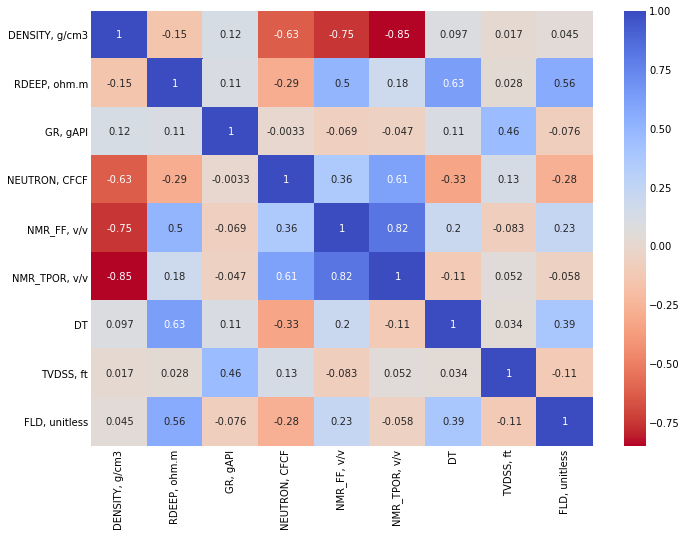

In [5]:
plt.figure(figsize=(10,8))
c = df[corr_features + ['TVDSS, ft', 'FLD, unitless']].corr(method ='spearman')    #pearson, kendall, spearman
sns.heatmap(c, cmap='coolwarm_r', annot=True)

In [6]:
print('Min depth:', df['TVDSS, ft'].min())
print('Max depth:', df['TVDSS, ft'].max())
print('Difference:', math.ceil(df['TVDSS, ft'].max() - df['TVDSS, ft'].min()))

Min depth: 24320.04
Max depth: 28559.0401761094
Difference: 4240


In [7]:
# ZERO DUPLICATES
df[df[corr_features].duplicated()]

,Well name,Field,Field part,"MD, ft","DENSITY, g/cm3","DTC, us/ft","DTS, US/F","FLD, unitless","GR, gAPI","NEUTRON, CFCF","NMR_BW, v/v","NMR_CBW, v/v","NMR_FF, v/v","NMR_TPOR, v/v","RDEEP, ohm.m","TVD, ft","TVDBML, ft","TVDSS, ft",Filename,wellName_old,datasetName,"RMEDIUM, ohm.m","RSHALLOW, ohm.m",DT


#### NO NEED TO SCALE BEFORE FEATURE GENERATION
to_stay = ['Well name', 'Field', 'Field part', 'MD, ft', 'FLD, unitless', 'Filename', 'wellName_old', 'datasetName',
          'TVD, ft', 'TVDBML, ft', 'TVDSS, ft',  ]
to_scale = [col for col in df.columns if col not in to_stay]

scaler = StandardScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])

In [8]:
df.describe()

,"MD, ft","DENSITY, g/cm3","DTC, us/ft","DTS, US/F","FLD, unitless","GR, gAPI","NEUTRON, CFCF","NMR_BW, v/v","NMR_CBW, v/v","NMR_FF, v/v","NMR_TPOR, v/v","RDEEP, ohm.m","TVD, ft","TVDBML, ft","TVDSS, ft","RMEDIUM, ohm.m","RSHALLOW, ohm.m",DT
count,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14273.000000,14249.000000,14273.000000,14273.000000,3899.000000,7330.000000,14273.000000
mean,26173.766896,2.257738,88.286644,150.883623,1.876900,33.679270,0.268774,0.055986,0.009714,0.155509,0.221209,0.325711,25589.165267,18219.939894,25510.567524,-0.009490,0.387352,0.587206
std,956.401021,0.072493,6.667169,14.942749,0.328563,5.831928,0.038503,0.025743,0.010559,0.050017,0.040708,0.496396,1140.328829,1110.746860,1130.774351,0.404960,0.536337,0.031779
min,24515.500000,2.070800,59.988460,96.756100,1.000000,12.798500,0.110347,0.002650,0.000000,0.001152,0.014340,-0.844847,24398.360000,16949.040000,24320.040000,-0.805655,-0.786274,0.510565
25%,25596.250000,2.208708,83.957300,140.160600,2.000000,29.930010,0.248536,0.038649,0.001395,0.119026,0.195283,-0.019315,24880.450000,17507.640000,24804.350000,-0.258043,-0.061483,0.561798
50%,25947.750000,2.256796,88.066930,151.326900,2.000000,33.322400,0.274023,0.050357,0.006341,0.158618,0.220415,0.387888,25253.000000,17931.910000,25181.750000,-0.033886,0.492984,0.585129
75%,26404.386719,2.300160,92.978150,160.722900,2.000000,37.010960,0.296207,0.066569,0.014580,0.193405,0.250058,0.672914,25658.360000,18350.490000,25590.100000,0.289896,0.782214,0.609425
max,28694.603041,3.112600,104.732800,192.824000,2.000000,114.353900,0.385244,0.163572,0.077707,0.295275,0.339213,1.478986,28661.040176,21187.040176,28559.040176,1.424346,1.505512,0.824567


In [9]:
df.isna().sum()

Well name              0
Field                  0
Field part          7027
MD, ft                 0
DENSITY, g/cm3         0
DTC, us/ft             0
DTS, US/F              0
FLD, unitless          0
GR, gAPI               0
NEUTRON, CFCF          0
NMR_BW, v/v            0
NMR_CBW, v/v           0
NMR_FF, v/v            0
NMR_TPOR, v/v          0
RDEEP, ohm.m           0
TVD, ft               24
TVDBML, ft             0
TVDSS, ft              0
Filename               0
wellName_old           0
datasetName            0
RMEDIUM, ohm.m     10374
RSHALLOW, ohm.m     6943
DT                     0
dtype: int64

## Additional features

In [10]:
# preliminary estimation of the optimal size of a depth bin
print('Preliminary estimation\n')
for well in df['Well name'].unique():
        
    temp = df[df['Well name'] == well]
    num = temp.shape[0]
    print('\t{}: {} datapoints'.format(well, num))
    
    interval = 5                                               # num of feet in an interval
    mini = temp['TVDSS, ft'].min()
    maxi = temp['TVDSS, ft'].max()
    print('\t\tTVDSS min: {:<8}, max: {:<8}, difference: {:<7} feet'.format(round(mini, 2), round(maxi, 2), round((maxi - mini), 2)))
    print('\t\t{} feet = {:<4} datapoints'.format(interval, round((num/(maxi - mini))*interval, 2)))
    print('\t\tNumber of bins:', round((maxi - mini)/interval, 2))

Preliminary estimation

	MC348-3ST1: 551 datapoints
		TVDSS min: 25140.8 , max: 25261.87, difference: 121.07  feet
		5 feet = 22.76 datapoints
		Number of bins: 24.21
	MC391-1: 2713 datapoints
		TVDSS min: 24755.8 , max: 25309.49, difference: 553.69  feet
		5 feet = 24.5 datapoints
		Number of bins: 110.74
	MC392-1: 950 datapoints
		TVDSS min: 24439.64, max: 24914.13, difference: 474.49  feet
		5 feet = 10.01 datapoints
		Number of bins: 94.9
	MC392-1ST1: 3032 datapoints
		TVDSS min: 25265.89, max: 25819.6 , difference: 553.71  feet
		5 feet = 27.38 datapoints
		Number of bins: 110.74
	MC393-1: 3679 datapoints
		TVDSS min: 24320.04, max: 25005.89, difference: 685.85  feet
		5 feet = 26.82 datapoints
		Number of bins: 137.17
	MC525-2: 1173 datapoints
		TVDSS min: 25065.63, max: 25651.63, difference: 586.0   feet
		5 feet = 10.01 datapoints
		Number of bins: 117.2
	MC612-1BP1: 2175 datapoints
		TVDSS min: 27479.81, max: 28559.04, difference: 1079.23 feet
		5 feet = 10.08 datapoints
		Num

In [11]:
df.index

RangeIndex(start=0, stop=14273, step=1)

call function from a module using its string name: fc.abs_energy(t) == getattr(fc, 'abs_energy')(t)

In [12]:
# rename df columns for better combination with function calls for additional features
df = df.rename(columns = {'Well name': 'wellname', 'Field':'field', 'Field part':'field_part', 'MD, ft':'md_ft',
                         'DENSITY, g/cm3':'density_g_cm3', 'DTC, us/ft':'dtc_us_ft', 'DTS, US/F':'dts_us_ft',
                         'FLD, unitless':'fluid', 'GR, gAPI':'gr_gapi', 'NEUTRON, CFCF':'neutron_cfcf',
                         'NMR_BW, v/v':'nmr_bw_vv', 'NMR_CBW, v/v':'nmr_cbw_vv', 'NMR_FF, v/v':'nmr_ff_vv',
                         'NMR_TPOR, v/v':'nmr_tpor_vv', 'RDEEP, ohm.m':'rdeep_ohm_m', 'TVD, ft':'tvd_ft',
                         'TVDBML, ft':'tvdbml_ft', 'TVDSS, ft':'tvdss_ft', 'Filename':'filename',
                         'wellName_old':'wellname_old', 'datasetName':'dataset_name', 'RMEDIUM, ohm.m':'rmedium_ohm_m',
                         'RSHALLOW, ohm.m':'rshallow_ohm_m', 'DT':'dt'})
corr_features = ['density_g_cm3', 'rdeep_ohm_m', 'gr_gapi', 'neutron_cfcf', 'nmr_ff_vv', 'nmr_tpor_vv', 'dt']

In [15]:
# functions to call on a time series to create additional features
functions = [
'abs_energy',
'absolute_sum_of_changes',
'cid_ce',                                                            #(t, normalize=False))
'count_above_mean',
'count_below_mean',
'first_location_of_maximum',
'first_location_of_minimum',
'last_location_of_maximum',
'last_location_of_minimum',
'has_duplicate_max',
'has_duplicate_min',
'kurtosis',
'longest_strike_above_mean',
'longest_strike_below_mean',
'minimum',
'maximum',
'mean',
'median',
'mean_change',
'mean_abs_change',
'mean_second_derivative_central',
'percentage_of_reoccurring_datapoints_to_all_datapoints',
'ratio_beyond_r_sigma',                                               # (t, 3) = 3 std away (or 2?)
'ratio_value_number_to_time_series_length',
'sample_entropy',
'skewness',
'standard_deviation',
'sum_of_reoccurring_data_points',
'sum_of_reoccurring_values',
'sum_values',
'variance',
'variation_coefficient'
]

In [16]:
len(functions)

32

In [17]:
# create all required extra columns for extra features
print(' Current size of data:', df.shape)
print('Estimated new columns:', len(corr_features) * len(functions))

for col in corr_features:
    for function in functions:
        df[col + '_' + function] = np.nan
                
print('Final size of data:', df.shape)

 Current size of data: (14273, 24)
Estimated new columns: 224
Final size of data: (14273, 248)


In [18]:
# function to get a time series - 7 data points above the current data point and 7 datapoints down. TOTAL: 15 data points
def get_range(idx, n=7):
    
    idxs = []
    for i in range(n, 0, -1):
        if idx - i >= df.index.min():
            idxs.append(idx - i)
    
    idxs.append(idx)
            
    for i in range(1, n+1):
        if idx + i <= df.index.max():
            idxs.append(idx + i)
            
    return idxs

In [19]:
# populate extra features with values in one column
def populate_column(corr_feat, func):
    
    res_col = corr_feat + '_' + func
    for row_idx in df.index:
        window = get_range(row_idx)
        time_series = df[corr_feat].loc[window].tolist()        
                
        if func == 'cid_ce':
            res_val = getattr(fc, func)(time_series, normalize=False)
        elif func == 'ratio_beyond_r_sigma':
            res_val = getattr(fc, func)(time_series, 2)
        else:
            res_val = getattr(fc, func)(time_series)

        df.loc[row_idx, res_col] = res_val         

In [20]:
for col in corr_features:
    for function in functions:
        populate_column(col, function)

C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1577: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1577: RuntimeWarning: invalid value encountered in long_scalars
  return -np.log(A / B)


In [21]:
df.head(50)

,wellname,field,field_part,md_ft,density_g_cm3,dtc_us_ft,dts_us_ft,fluid,gr_gapi,neutron_cfcf,nmr_bw_vv,nmr_cbw_vv,nmr_ff_vv,nmr_tpor_vv,rdeep_ohm_m,tvd_ft,tvdbml_ft,tvdss_ft,filename,wellname_old,dataset_name,rmedium_ohm_m,rshallow_ohm_m,dt,density_g_cm3_abs_energy,density_g_cm3_absolute_sum_of_changes,density_g_cm3_cid_ce,density_g_cm3_count_above_mean,density_g_cm3_count_below_mean,density_g_cm3_first_location_of_maximum,density_g_cm3_first_location_of_minimum,density_g_cm3_last_location_of_maximum,density_g_cm3_last_location_of_minimum,density_g_cm3_has_duplicate_max,density_g_cm3_has_duplicate_min,density_g_cm3_kurtosis,density_g_cm3_longest_strike_above_mean,density_g_cm3_longest_strike_below_mean,density_g_cm3_minimum,density_g_cm3_maximum,density_g_cm3_mean,density_g_cm3_median,density_g_cm3_mean_change,density_g_cm3_mean_abs_change,density_g_cm3_mean_second_derivative_central,density_g_cm3_percentage_of_reoccurring_datapoints_to_all_datapoints,density_g_cm3_ratio_beyond_r_sigma,density_g_cm3_ratio_value_number_to_time_series_length,density_g_cm3_sample_entropy,density_g_cm3_skewness,density_g_cm3_standard_deviation,density_g_cm3_sum_of_reoccurring_data_points,density_g_cm3_sum_of_reoccurring_values,density_g_cm3_sum_values,density_g_cm3_variance,density_g_cm3_variation_coefficient,rdeep_ohm_m_abs_energy,rdeep_ohm_m_absolute_sum_of_changes,rdeep_ohm_m_cid_ce,rdeep_ohm_m_count_above_mean,rdeep_ohm_m_count_below_mean,rdeep_ohm_m_first_location_of_maximum,rdeep_ohm_m_first_location_of_minimum,rdeep_ohm_m_last_location_of_maximum,rdeep_ohm_m_last_location_of_minimum,rdeep_ohm_m_has_duplicate_max,rdeep_ohm_m_has_duplicate_min,rdeep_ohm_m_kurtosis,rdeep_ohm_m_longest_strike_above_mean,rdeep_ohm_m_longest_strike_below_mean,rdeep_ohm_m_minimum,rdeep_ohm_m_maximum,rdeep_ohm_m_mean,rdeep_ohm_m_median,rdeep_ohm_m_mean_change,rdeep_ohm_m_mean_abs_change,rdeep_ohm_m_mean_second_derivative_central,rdeep_ohm_m_percentage_of_reoccurring_datapoints_to_all_datapoints,rdeep_ohm_m_ratio_beyond_r_sigma,rdeep_ohm_m_ratio_value_number_to_time_series_length,rdeep_ohm_m_sample_entropy,rdeep_ohm_m_skewness,rdeep_ohm_m_standard_deviation,rdeep_ohm_m_sum_of_reoccurring_data_points,rdeep_ohm_m_sum_of_reoccurring_values,rdeep_ohm_m_sum_values,rdeep_ohm_m_variance,rdeep_ohm_m_variation_coefficient,gr_gapi_abs_energy,gr_gapi_absolute_sum_of_changes,gr_gapi_cid_ce,gr_gapi_count_above_mean,gr_gapi_count_below_mean,gr_gapi_first_location_of_maximum,gr_gapi_first_location_of_minimum,gr_gapi_last_location_of_maximum,gr_gapi_last_location_of_minimum,gr_gapi_has_duplicate_max,gr_gapi_has_duplicate_min,gr_gapi_kurtosis,gr_gapi_longest_strike_above_mean,gr_gapi_longest_strike_below_mean,gr_gapi_minimum,gr_gapi_maximum,gr_gapi_mean,gr_gapi_median,gr_gapi_mean_change,gr_gapi_mean_abs_change,gr_gapi_mean_second_derivative_central,gr_gapi_percentage_of_reoccurring_datapoints_to_all_datapoints,gr_gapi_ratio_beyond_r_sigma,gr_gapi_ratio_value_number_to_time_series_length,gr_gapi_sample_entropy,gr_gapi_skewness,gr_gapi_standard_deviation,gr_gapi_sum_of_reoccurring_data_points,gr_gapi_sum_of_reoccurring_values,gr_gapi_sum_values,gr_gapi_variance,gr_gapi_variation_coefficient,neutron_cfcf_abs_energy,neutron_cfcf_absolute_sum_of_changes,neutron_cfcf_cid_ce,neutron_cfcf_count_above_mean,neutron_cfcf_count_below_mean,neutron_cfcf_first_location_of_maximum,neutron_cfcf_first_location_of_minimum,neutron_cfcf_last_location_of_maximum,neutron_cfcf_last_location_of_minimum,neutron_cfcf_has_duplicate_max,neutron_cfcf_has_duplicate_min,neutron_cfcf_kurtosis,neutron_cfcf_longest_strike_above_mean,neutron_cfcf_longest_strike_below_mean,neutron_cfcf_minimum,neutron_cfcf_maximum,neutron_cfcf_mean,neutron_cfcf_median,neutron_cfcf_mean_change,neutron_cfcf_mean_abs_change,neutron_cfcf_mean_second_derivative_central,neutron_cfcf_percentage_of_reoccurring_datapoints_to_all_datapoints,neutron_cfcf_ratio_beyond_r_sigma,neutron_cfcf_ratio_value_number_to_time_series_length,neutron_cfcf_sam

In [22]:
df.to_csv('norphlet_subset_moving_window_additional_features_20200704.csv', encoding='utf8', index='False')

## Appendix (irrelevant)

### Trial of the new feature generation package

In [ ]:
t = [0,1,2,3,4,5,6,7,8,9]

In [ ]:
print(fc.abs_energy(t))
print(fc.absolute_sum_of_changes(t))
print(fc.cid_ce(t, normalize=False))
print(fc.count_above_mean(t))
print(fc.count_below_mean(t))
print(fc.first_location_of_maximum(t))
print(fc.first_location_of_minimum(t))
print(fc.last_location_of_maximum(t))
print(fc.last_location_of_minimum(t))
print(fc.has_duplicate_max(t))
print(fc.has_duplicate_min(t))

In [ ]:
print(fc.kurtosis(t))
print(fc.longest_strike_above_mean(t))
print(fc.longest_strike_below_mean(t))
print(fc.minimum(t))
print(fc.maximum(t))
print(fc.mean(t))
print(fc.median(t))
print(fc.mean_change(t))
print(fc.mean_abs_change(t))
print(fc.mean_second_derivative_central(t))

In [ ]:
print(fc.percentage_of_reoccurring_datapoints_to_all_datapoints(t))
print(fc.ratio_beyond_r_sigma(t, 2))
print(fc.ratio_value_number_to_time_series_length(t))
print(fc.sample_entropy(t))
print(fc.skewness(t))
print(fc.standard_deviation(t))
print(fc.sum_of_reoccurring_data_points(t))
print(fc.sum_of_reoccurring_values(t))
print(fc.sum_values(t))
print(fc.variance(t))
print(fc.variation_coefficient(t))